# 项目介绍

- 本项目来源与Kaggle Titanic - Machine Learning from Disaster，通过已有的乘客数据，训练模型，预测乘客遇难后的获救率。
- 本项目利用pandas进行数据分析，seaborn和matplotlib进行可视化，利用了sklearn中逻辑回归、支持向量机、随机森林、K近邻等模型进行预测。
- 项目中数据分析部分：
    - 对空值进行了处理；
    - 对特征进行分类，并对各类特征进行探索性分析，探索各特征之间的关系，尤其是各特征与核心特征Survival之间的关系；
    - 进行特征工程，让特征方便建模：包括分箱、one-hot encoding；从现有特征中提取创建新特征；删除对建模意义不大的特征。    

# 理解数据

## 导入库

In [264]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

## 导入数据

In [265]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

In [266]:
train_data.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

- Survived: 0=没有获救，1=获救 
- Pclass：乘客等级
- Name：姓名（包括title）
- Sex：性别
- SibSp：同伴数量
- Parch：父母/孩子数量
- Ticket：船票号
- Fare：船票价格
- Cabin：船舱号
- Embarked：登船口

## 数据信息

In [267]:
train_data.info()
print('-'*45)
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
---------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Pass

- 特征类型：
    - Categorical：survived, sex, embarked, pclass
    - Numerical: age(continuous), fare(continuous), siibsp (discrete), parch (discrete)
    - Alphanumeric: ticket, cabin

- 存在空值：cabin, age, embarked

- 特征的 data type：
    - integer, floats
    - strings(object)

In [268]:
# 数据统计信息
train_data.describe()

PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200

- 总体：样本数据共891名，其中39%的人获救。
- age：乘客平均年龄约为30岁，75%的乘客在38岁及以下，年老乘客占比少。
- SibSp：50%以上的乘客没有跟兄弟姐妹/朋友一起。
- Parch：75%以上的乘客没有跟父母或子女一起。
- Fare：船票价格波动非常大，平均价格为32刀，最高价达512刀。

In [269]:
train_data.describe(include=['O'])

Name   Sex    Ticket        Cabin Embarked
count                          891   891       891          204      889
unique                         891     2       681          147        3
top     Moore, Mr. Leonard Charles  male  CA. 2343  C23 C25 C27        S
freq                             1   577         7            4      644

- Name：样本数据中，乘客姓名没有出现重名的情况。
- Sex：65%的乘客为男性，共577名。
- Ticket：23%的ticket船票编号重复。
- Cabin：cabin客舱号存在重复，说明有多名乘客共用一间。
- Embarked：S登船港口人数最多。

# 数据分析

In [301]:
combine = [train_data, test_data]

## 处理空值

### Age
- 取相同性别、相同船舱等级乘客的年龄中位数进行填充

In [271]:
from sklearn.ensemble import RandomForestRegressor
age = train_data[['Age', 'Pclass', 'SibSp', 'Parch']]

know_age = age[age['Age'].notnull()].values
unknow_age = age[age['Age'].isnull()].values

X = know_age[:, 1:]
y = know_age[:, 0]

rf = RandomForestRegressor(random_state=0, n_estimators=1000, n_jobs=-1)
rf.fit(X,y)

predictAge = rf.predict(unknow_age[:, 1::])
train_data.loc[(train_data.Age.isnull()), 'Age'] = predictAge

In [272]:
from sklearn.ensemble import RandomForestRegressor
age = test_data[['Age', 'Pclass', 'SibSp', 'Parch']]

know_age = age[age['Age'].notnull()].values
unknow_age = age[age['Age'].isnull()].values

X = know_age[:, 1:]
y = know_age[:, 0]

rf = RandomForestRegressor(random_state=0, n_estimators=1000, n_jobs=-1)
rf.fit(X,y)

predictAge = rf.predict(unknow_age[:, 1::])
test_data.loc[(test_data.Age.isnull()), 'Age'] = predictAge

In [273]:
#for dataset in combine:
 #   dataset['Age'] = dataset.groupby(['Sex', 'Pclass'])['Age'].apply(lambda x: x.fillna(x.median()))

### Fare
- test数据集中有一个空值，用中位数填充

In [274]:
test_data['Fare'].isnull().sum()

1

In [275]:
test_data['Fare'].fillna(test_data['Fare'].dropna().median(), inplace=True)
test_data.head()

PassengerId  Pclass                                          Name     Sex  \
0          892       3                              Kelly, Mr. James    male   
1          893       3              Wilkes, Mrs. James (Ellen Needs)  female   
2          894       2                     Myles, Mr. Thomas Francis    male   
3          895       3                              Wirz, Mr. Albert    male   
4          896       3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)  female   

    Age  SibSp  Parch   Ticket     Fare Cabin Embarked  
0  34.5      0      0   330911   7.8292   NaN        Q  
1  47.0      1      0   363272   7.0000   NaN        S  
2  62.0      0      0   240276   9.6875   NaN        Q  
3  27.0      0      0   315154   8.6625   NaN        S  
4  22.0      1      1  3101298  12.2875   NaN        S

### Embarked

In [276]:
train_data['Embarked'].isnull().sum()

2

In [277]:
# 使用出现率最高值进行填充
freq_port = train_data.Embarked.dropna().mode()[0]
freq_port

'S'

In [278]:
train_data['Embarked'] = train_data['Embarked'].fillna(freq_port)

### Cabin

In [279]:
train_data['Cabin'].isnull().sum()

687

- 虽然Cabin存在大量空值，但是考虑到Cabin与Pclass可能有一定的关联性，暂时不考虑删除这个特征。
- cabin的首字母可能是所在甲板区域代码，可以提取出来作为新特征Deck，空值用'M'代替填充。--> 在特征工程中进行

## 探索性分析

Text(0.5, 1.0, 'Survival (1 = survived, 0 = died)')

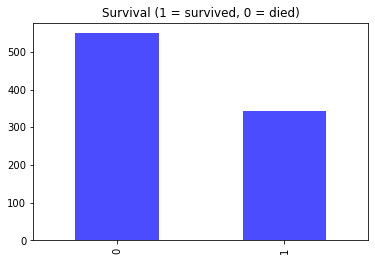

In [280]:
# 整体乘客存活情况
train_data.Survived.value_counts().plot(kind='bar',color='blue', alpha=0.7)
plt.title('Survival (1 = survived, 0 = died)')

### 分类特征
- pclass, sex, embarked

Pclass
- 获救几率由大到小排序：1>2>3，说明等级越高，获救几率越大。

In [281]:
train_data[['Cabin', 'Survived']].groupby(['Cabin']).mean().sort_values(by='Survived',ascending=False)

Survived
Cabin            
C62 C64       1.0
D21           1.0
D17           1.0
D19           1.0
C148          1.0
...           ...
C46           0.0
C30           0.0
C128          0.0
C124          0.0
T             0.0

[147 rows x 1 columns]

In [282]:
train_data[['Pclass', 'Survived']].groupby(['Pclass']).mean().sort_values(by='Survived',ascending=False)

Survived
Pclass          
1       0.629630
2       0.472826
3       0.242363

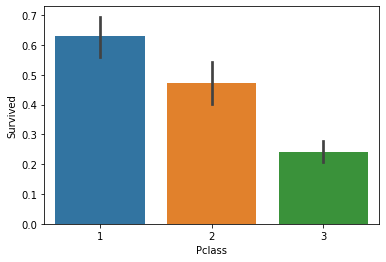

In [283]:
g = sns.barplot(x='Pclass', y='Survived', data=train_data)

Sex
- 女性的获救几率高于男性。因此，性别与获救率有关。

In [284]:
train_data[['Sex','Survived']].groupby(['Sex']).mean().sort_values(by='Survived',ascending=False)

Survived
Sex             
female  0.742038
male    0.188908

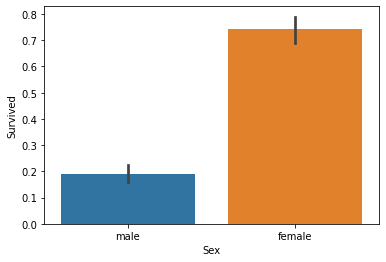

In [285]:
g = sns.barplot(x='Sex', y='Survived', data=train_data)

Embarked

In [286]:
train_data[['Embarked','Survived']].groupby(['Embarked']).mean().sort_values(by='Survived',ascending=False)

Survived
Embarked          
C         0.553571
Q         0.389610
S         0.339009

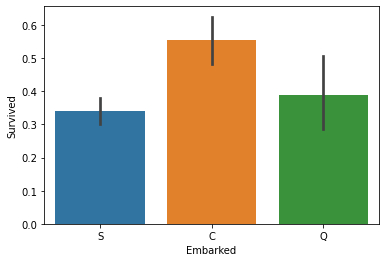

In [287]:
g = sns.barplot(x='Embarked', y='Survived', data=train_data)

- 从C口登船的乘客，存活率比较高。
- 可能不同Pclass的登船口不同，因此需要进一步分析。

/Users/yangtao/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/Users/yangtao/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:3720: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/Users/yangtao/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


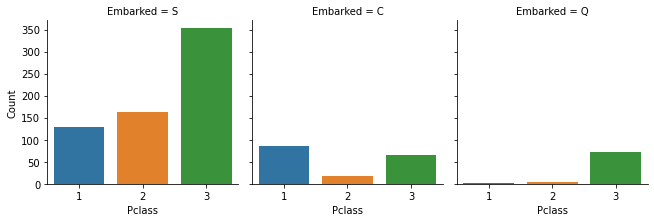

In [288]:
g = sns.factorplot("Pclass", col="Embarked", size=3, data=train_data, kind="count")
g = g.set_ylabels("Count")

/Users/yangtao/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/Users/yangtao/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:3720: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/Users/yangtao/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


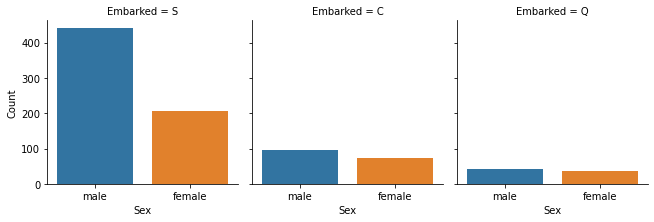

In [289]:
g = sns.factorplot("Sex", col="Embarked", size=3, data=train_data, kind="count")
g = g.set_ylabels("Count")

- 登船乘客的性别和和舱位等级对影响了每个登船口的survival几率。
- C口存活率最高，同时Pclass=1的乘客比例高，且乘客性别比例比较平均。
- S口存活率最低，同时Pclass=3的乘客比例高，且男性数量是女性的2倍。

### 数值特征

<AxesSubplot:>

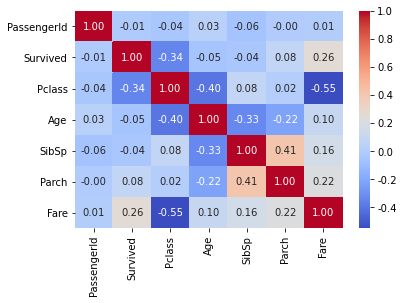

In [290]:
# Correlation Matrix
sns.heatmap(train_data.corr(), annot=True, fmt='0.2f', cmap='coolwarm')

Age

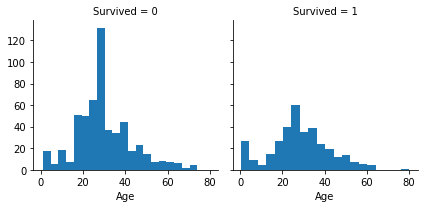

In [291]:
g = sns.FacetGrid(train_data, col='Survived')
g = g.map(plt.hist, 'Age', bins=20)

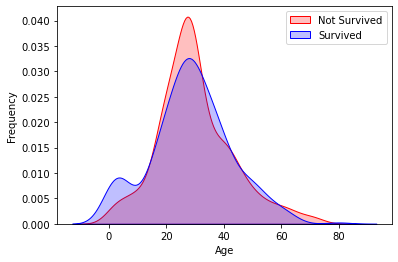

In [292]:
g = sns.kdeplot(train_data['Age'][(train_data['Survived']==0) & (train_data['Age'].notnull())], color='r', shade=True)
g = sns.kdeplot(train_data['Age'][(train_data['Survived']==1) & (train_data['Age'].notnull())], color='b', shade=True)
g.set_xlabel("Age")
g.set_ylabel("Frequency")
g = g.legend(["Not Survived","Survived"])

- 婴儿到青少年有比较高的存活率。
- 超过60岁的老年人存活率低，但是最年老的乘客（80岁）存活率较高。
- 大量16-32岁的年轻人没有存活。
- 大部分乘客为16-40岁的中青年。

Fare

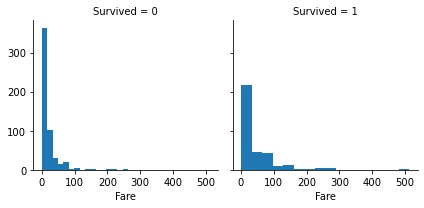

In [293]:
g = sns.FacetGrid(train_data, col='Survived')
g.map(plt.hist, 'Fare', bins=16)

- 两种情况下，都出现了左偏分布。
- 根据经验，票价越高，船舱等级越高，因此加入Pclass条件，将票价进行分类再分析。

/Users/yangtao/opt/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:643: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


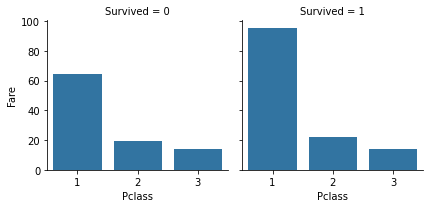

In [294]:
grid = sns.FacetGrid(train_data, col='Survived')
grid.map(sns.barplot, 'Pclass', 'Fare', ci=None)
grid.add_legend()

- 可以看出，相同Pclass，票价越高，存活几率越大。

SibSp

In [295]:
train_data[['SibSp','Survived']].groupby(['SibSp']).mean().sort_values(by='Survived',ascending=False)

Survived
SibSp          
1      0.535885
2      0.464286
0      0.345395
3      0.250000
4      0.166667
5      0.000000
8      0.000000

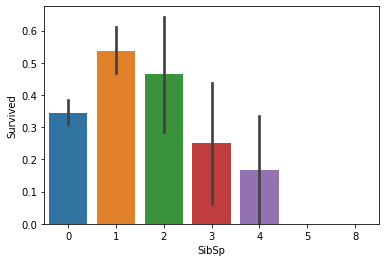

In [296]:
g = sns.barplot(x='SibSp', y='Survived', data=train_data)

- 同伴越多，获救率越低。
- 拥有1个同伴获救率最高，其次为2个和单身。

Parch

In [297]:
train_data[['Parch','Survived']].groupby(['Parch']).mean().sort_values(by='Survived',ascending=False)

Survived
Parch          
3      0.600000
1      0.550847
2      0.500000
0      0.343658
5      0.200000
4      0.000000
6      0.000000

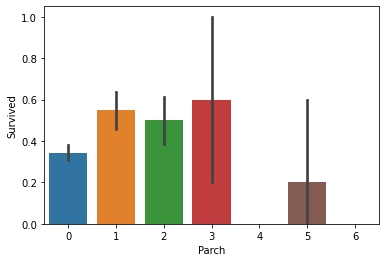

In [298]:
g = sns.barplot(x='Parch', y='Survived', data=train_data)

- 有3名家庭成员的获救几率最大，但是SD波动也比较大。

## 特征工程

### 分箱连续数值型特征

#### Age

In [299]:
train_data['AgeBand'] = pd.cut(train_data['Age'], 5)
train_data[['AgeBand', 'Survived']].groupby(['AgeBand'], as_index=False).mean().sort_values(by='AgeBand')

AgeBand  Survived
0    (0.34, 16.336]  0.486726
1  (16.336, 32.252]  0.345416
2  (32.252, 48.168]  0.410480
3  (48.168, 64.084]  0.434783
4    (64.084, 80.0]  0.090909

#### Fare

In [300]:
train_data['FareBand'] = pd.qcut(train_data['Fare'], 4) #qcut:按照分位数分箱
train_data[['FareBand', 'Survived']].groupby(['FareBand'], as_index=False).mean().sort_values(by='FareBand', \
                                                                                              ascending=True)                  

FareBand  Survived
0   (-0.001, 7.91]  0.197309
1   (7.91, 14.454]  0.303571
2   (14.454, 31.0]  0.454955
3  (31.0, 512.329]  0.581081

### 创建新特征

#### Deck

In [302]:
for dataset in combine:
    dataset['Deck'] = dataset['Cabin'].apply(lambda x: x[0] if pd.notnull(x) else 'M')

In [306]:
train_data[['Deck', 'Survived']].groupby('Deck', as_index=False).mean().sort_values(by='Survived', ascending=False)

Deck  Survived
1    DE  0.753846
0  ABCT  0.631148
2    FG  0.588235
3     M  0.299854

In [305]:
train_data.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked           AgeBand  \
0      0         A/5 21171   7.2500   NaN        S  (16.336, 32.252]   
1      0          PC 17599  71.2833   C85        C  (32.252, 48.168]   
2      0  STON/O2. 3101282   7.9250   NaN        S  (16.336, 32.252]   
3      0            113803  53.1000  C123        S  (32.252, 48.168]   
4      0            373450   8.0500   NaN        S  (32.252, 48.168]   

          FareBand  Deck  
0   (-0.001, 7.91]     M  
1  (31.0, 512.329]  ABCT  
2   (7.91, 14.454]     M  
3  (31.0, 512.329]  ABCT  
4   (7.91, 14.454]     M

/Users/yangtao/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/Users/yangtao/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:3720: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/Users/yangtao/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


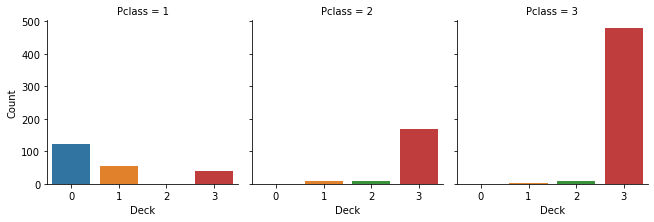

In [342]:
g = sns.factorplot("Deck", col="Pclass", size=3, data=train_data, kind="count")
g = g.set_ylabels("Count")

- 登记过cabin的乘客存活率要高于没有登记的乘客，可见是否登记客舱号与生存率有一定关联
- 绝大部分没有登记过cabin的乘客都来自3等，印证了之前观察到的’pclass低，存活率低’观点。
- 根据Deck所属Pclass可以将Deck进行划分：
    - A,B,C,T都来自于1等
    - M单独为一类
    - DE大部分来自于1、2等，且存活率相近，为一类
    - 剩余F在2、3等均有分布，G都来自于3等，可分为一类

In [304]:
for dataset in combine:
    dataset['Deck'] = dataset['Deck'].replace(['A', 'B', 'C', 'T'], 'ABCT')
    dataset['Deck'] = dataset['Deck'].replace(['D', 'E'], 'DE')
    dataset['Deck'] = dataset['Deck'].replace(['F', 'G'], 'FG')

In [307]:
train_data[['Deck', 'Survived']].groupby('Deck', as_index=False).mean().sort_values(by='Survived', ascending=False)

Deck  Survived
1    DE  0.753846
0  ABCT  0.631148
2    FG  0.588235
3     M  0.299854

#### FamilySize
- 利用Parch和SibSp来创建FamilySize

In [308]:
for dataset in combine:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
    
train_data[['FamilySize', 'Survived']].groupby('FamilySize', as_index=False).mean().sort_values(by='Survived', \
                                                                                                ascending=False)

FamilySize  Survived
3           4  0.724138
2           3  0.578431
1           2  0.552795
6           7  0.333333
0           1  0.303538
4           5  0.200000
5           6  0.136364
7           8  0.000000
8          11  0.000000

#### Title

In [309]:
for dataset in combine:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

pd.crosstab(train_data.Title, train_data.Sex)

Sex       female  male
Title                 
Capt           0     1
Col            0     2
Countess       1     0
Don            0     1
Dr             1     6
Jonkheer       0     1
Lady           1     0
Major          0     2
Master         0    40
Miss         182     0
Mlle           2     0
Mme            1     0
Mr             0   517
Mrs          125     0
Ms             1     0
Rev            0     6
Sir            0     1

- 从特征Name中提取出Title，需要对所有Title进行归类；
- 如女性title中，Countess、Lady，Mlle，Mme，Ms都归为Miss中；
- Capt, Col, Don, Dr, Jonkheer, Major, Rev, Sir 都比较少见，归为Rare；

In [310]:
for dataset in combine:
    dataset['Title'] = dataset['Title'].replace(['Capt', 'Col', 'Don', 'Jonkheer', 'Rev', \
                                                'Major', 'Sir', 'Dr'], 'Rare')
    dataset['Title'] = dataset['Title'].replace(['Countess', 'Lady', 'Mlle', 'Mme', 'Ms'], 'Miss')

train_data[['Title', 'Survived']].groupby('Title', as_index=False).mean()

Title  Survived
0  Master  0.575000
1    Miss  0.707447
2      Mr  0.156673
3     Mrs  0.792000
4    Rare  0.285714

#### Is_Married
- 从Mrs，可以得到女性已婚信息，也就是说，是否已婚女性获救率要高于单身女性？

In [311]:
for dataset in combine:
    dataset['Is_Married'] = 0
    dataset['Is_Married'].loc[dataset['Title'] == 'Mrs'] = 1
    
train_data[['Sex', 'Is_Married', 'Survived']].groupby(['Sex','Is_Married'], as_index=False).mean()

/Users/yangtao/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Sex  Is_Married  Survived
0  female           0  0.708995
1  female           1  0.792000
2    male           0  0.188908

- 已婚女性的获救率的确要微高于单身女性。

### One-Hot Encoding

In [312]:
sex_mapping = {'male': 0, 'female': 1}
em_mapping = {'S': 0, 'C': 1, 'Q': 2}
title_mapping = {"Mr": 0, "Miss": 1, "Mrs": 2, "Master": 3, "Rare": 4}
deck_mapping = {'ABCT': 0, 'DE': 1, 'FG': 2, 'M': 3}

In [313]:
for dataset in combine:
    # Sex
    dataset['Sex'] = dataset['Sex'].map(sex_mapping).astype(int)
    # Embarked
    dataset['Embarked'] = dataset['Embarked'].map(em_mapping).astype(int)
    # Title
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
    # Deck
    dataset['Deck'] = dataset['Deck'].map(deck_mapping).astype(int)

In [314]:
for dataset in combine:
    # Fare
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)

In [315]:
for dataset in combine:
    # Age
    dataset.loc[dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age']  

In [316]:
for dataset in combine:
    # FamilySize
    dataset.loc[ dataset['FamilySize'] ==1, 'FamilySize'] = 0
    dataset.loc[(dataset['FamilySize'] > 1) & (dataset['FamilySize'] <= 4), 'FamilySize'] = 1
    dataset.loc[(dataset['FamilySize'] > 4) & (dataset['FamilySize'] <= 6), 'FamilySize'] = 2
    dataset.loc[ dataset['FamilySize'] > 6, 'FamilySize'] = 3
    dataset['FamilySize'] = dataset['FamilySize'].astype(int)

- 可以将得到的FamilySize进行分组：
    - FamilySize为1，代表乘客独自1人登船，则FamilySize=0
    - FamilySize在2-4之间，为小型家庭，则FamilySize=1
    - FamilySize在5-6之间，为中型家庭，则FamilySize=2
    - FamilySize大于6，为大型家庭，则FamilySize=3

### 删除不需要的特征

Tiket & Cabin & Name & PassebgerId & Parch & SibSp

In [317]:
train_data = train_data.drop(['Ticket','Cabin','Name', 'PassengerId'], axis=1)
test_data = test_data.drop(['Ticket','Cabin', 'Name'], axis=1)

In [318]:
train_data = train_data.drop(['Parch', 'SibSp'], axis=1)
test_data = test_data.drop(['Parch', 'SibSp'], axis=1)

之前创建的AgeBand，FareBand

In [319]:
train_data = train_data.drop(['AgeBand','FareBand'], axis=1)
combine = [train_data, test_data]

In [320]:
train_data.head()

Survived  Pclass  Sex  Age  Fare  Embarked  Deck  FamilySize  Title  \
0         0       3    0  1.0     0         0     3           1      0   
1         1       1    1  2.0     3         1     0           1      2   
2         1       3    1  1.0     1         0     3           0      1   
3         1       1    1  2.0     3         0     0           1      2   
4         0       3    0  2.0     1         0     3           0      0   

   Is_Married  
0           0  
1           1  
2           0  
3           1  
4           0

# 构建模型

In [321]:
X_train = train_data.drop('Survived', axis=1)
Y_train = train_data['Survived']
X_test = test_data.drop('PassengerId', axis=1).copy()
X_train.shape, Y_train.shape, X_test.shape

((891, 9), (891,), (418, 9))

## Logistic regression

In [322]:
logreg = LogisticRegression()
logreg.fit(X_train, Y_train)
Y_pred = logreg.predict(X_test)
acc_log = round(logreg.score(X_train, Y_train)*100, 2)
acc_log

79.35

In [323]:
coeff_data = pd.DataFrame(train_data.columns.delete(0)) #delete(0)删除第0行
coeff_data.columns = ['Feature']
coeff_data['Correlation'] = pd.Series(logreg.coef_[0])

coeff_data.sort_values(by='Correlation', ascending=False)

Feature  Correlation
1         Sex     2.206524
7       Title     0.499942
3        Fare     0.270472
4    Embarked     0.260067
8  Is_Married     0.021706
2         Age    -0.035421
5        Deck    -0.234505
0      Pclass    -0.505916
6  FamilySize    -0.661936

- Sex的系数值最大，即随着Sex值变大（male:0, female:1），Survived的可能性增高。
- FamilySze最低，也就是说，随着Size值增加，Survived的可能性下降。

## Support Vector Machines

In [340]:
svc = SVC()
svc.fit(X_train, Y_train)
Y_pred = svc.predict(X_test)
acc_svc = round(svc.score(X_train, Y_train) * 100, 2)
acc_svc

81.93

## KNN

In [338]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, Y_train)
Y_pred = knn.predict(X_test)
acc_knn = round(knn.score(X_train, Y_train)*100, 2)
acc_knn

86.08

## Gaussian Naive Bayes

In [326]:
gaussian = GaussianNB()
gaussian.fit(X_train, Y_train)
Y_pred = gaussian.predict(X_test)
acc_gaussian = round(gaussian.score(X_train, Y_train) * 100, 2)
acc_gaussian

76.77

## Perception

In [327]:
perceptron = Perceptron()
perceptron.fit(X_train, Y_train)
Y_pred = perceptron.predict(X_test)
acc_perceptron = round(perceptron.score(X_train, Y_train)*100, 2)
acc_perceptron

79.01

## Linear SVC

In [336]:
linear_svc = LinearSVC()
linear_svc.fit(X_train, Y_train)
Y_pred = linear_svc.predict(X_test)
acc_linear_svc = round(linear_svc.score(X_train, Y_train)*100, 2)
acc_linear_svc

/Users/yangtao/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


79.57

## Stochastic Gradient Descent

In [329]:
sgd = SGDClassifier()
sgd.fit(X_train, Y_train)
Y_pred = sgd.predict(X_test)
acc_sgd = round(sgd.score(X_train, Y_train) * 100, 2)
acc_sgd

76.54

## Desicion Tree

In [333]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)
Y_pred = decision_tree.predict(X_test)
acc_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 2)
acc_decision_tree

89.34

## Random Forest

In [335]:
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)
Y_pred = random_forest.predict(X_test)
random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
acc_random_forest

89.34

# 评估模型
- 在多个模型中选择最优模型

In [332]:
models = pd.DataFrame({
    'Model':['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 'Perceptron', 
              'Stochastic Gradient Decent', 'Linear SVC', 
              'Decision Tree'],
    'Score':[acc_svc, acc_knn, acc_log, 
              acc_random_forest, acc_gaussian, acc_perceptron, 
              acc_sgd, acc_linear_svc, acc_decision_tree]})
models.sort_values(by='Score', ascending=False)

Model  Score
3               Random Forest  89.34
8               Decision Tree  89.34
1                         KNN  86.08
0     Support Vector Machines  81.93
7                  Linear SVC  79.57
2         Logistic Regression  79.35
5                  Perceptron  79.01
4                 Naive Bayes  76.77
6  Stochastic Gradient Decent  76.54

In [341]:
submission = pd.DataFrame({
    'PassengerId': test_data['PassengerId'],
    'Survived': Y_pred
})
submission.to_csv('submission3.csv', index=False)